# Universidade de Fortaleza
## Mestrado em Informática Aplicada
### Ciência de Dados aplicada à Ciência da Cidade

por Eduardo Rebouças 2427804
Prof. Hygor Piaget em Dezembro/2025

# Trabalho Final: Localização Serviços Governamentais no Ceará

## Objetivo

Este notebook aplica conceitos de ciência de dados urbanos para determinar a localização ótima de serviços governamentais nos municípios do Ceará, utilizando métricas socioeconômicas do IPEADATA.

## Conceitos Aplicados

1. **Diagramas de Voronoi** - Alocação de áreas de serviço e análise de cobertura
2. **Clustering K-Means Ponderado** - Localização ótima de instalações usando pesos socioeconômicos

---
## 1. Configuração e Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import ipeadatapy as ipea
plt.style.use('seaborn-v0_8-whitegrid')

---
## 2. Carregamento de Dados

### 2.1 Carregar Municípios do Ceará com População e Coordenadas

Utilizaremos os dados de população existentes da análise de Zipf e adicionaremos coordenadas geográficas.

In [2]:
# Load population data from existing zipf analysis
df_pop = pd.read_csv("../02-zipf/ceara_cities.csv", skiprows=1)
df_pop.columns = [c.strip().replace("\ufeff", "") for c in df_pop.columns]

# Rename columns for clarity
df_pop = df_pop.rename(columns={"Código": "code", "Município": "city", "2022": "population"}).copy()
df_pop["population"] = pd.to_numeric(df_pop["population"], errors="coerce")
df_pop = df_pop.dropna(subset=["population"])
df_pop = df_pop[df_pop["population"] > 0].copy()

print(f"Loaded {len(df_pop)} municipalities from Ceará")
df_pop.head()

Loaded 184 municipalities from Ceará


/tmp/ipykernel_24091/2755758088.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pop["population"] = pd.to_numeric(df_pop["population"], errors="coerce")


,Sigla,code,city,population,Unnamed: 4
0,CE,2300101,Abaiara,10038.0,NaN
1,CE,2300150,Acarapé,14027.0,NaN
2,CE,2300200,Acaraú,65264.0,NaN
3,CE,2300309,Acopiara,44962.0,NaN
4,CE,2300408,Aiuaba,14076.0,NaN


In [3]:
# Load geographic coordinates
# Data source: https://github.com/kelvins/Municipios-Brasileiros
# Download CSV with lat/long for Brazilian municipalities

# Option 1: Download from GitHub
url_coords = "https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv"
df_coords = pd.read_csv(url_coords)

# Filter for Ceará (UF code 23)
df_coords_ce = df_coords[df_coords["codigo_uf"] == 23].copy()
df_coords_ce = df_coords_ce.rename(columns={"codigo_ibge": "code", "nome": "city_name", 
                                             "latitude": "lat", "longitude": "lon"})

print(f"Loaded coordinates for {len(df_coords_ce)} Ceará municipalities")
df_coords_ce.head()

Loaded coordinates for 184 Ceará municipalities


,code,city_name,lat,lon,capital,codigo_uf,siafi_id,ddd,fuso_horario
5,2300101,Abaiara,-7.34588,-39.0416,0,23,1301,88,America/Sao_Paulo
19,2300150,Acarape,-4.22083,-38.7055,0,23,1231,85,America/Sao_Paulo
20,2300200,Acaraú,-2.88769,-40.1183,0,23,1303,88,America/Sao_Paulo
24,2300309,Acopiara,-6.08911,-39.4480,0,23,1305,88,America/Sao_Paulo
83,2300408,Aiuaba,-6.57122,-40.1178,0,23,1307,88,America/Sao_Paulo


In [4]:
# Merge population and coordinates
df = df_pop.merge(df_coords_ce[["code", "lat", "lon"]], on="code", how="inner").copy()
print(f"Merged dataset: {len(df)} municipalities with population and coordinates")
df.head()

Merged dataset: 184 municipalities with population and coordinates


,Sigla,code,city,population,Unnamed: 4,lat,lon
0,CE,2300101,Abaiara,10038.0,NaN,-7.34588,-39.0416
1,CE,2300150,Acarapé,14027.0,NaN,-4.22083,-38.7055
2,CE,2300200,Acaraú,65264.0,NaN,-2.88769,-40.1183
3,CE,2300309,Acopiara,44962.0,NaN,-6.08911,-39.4480
4,CE,2300408,Aiuaba,14076.0,NaN,-6.57122,-40.1178


### 2.2 Carregar Dados Socioeconômicos do IPEADATA

Buscaremos o IDHM (Índice de Desenvolvimento Humano Municipal) do Atlas do Desenvolvimento Humano, que fornece indicadores de desenvolvimento humano em nível municipal.

In [5]:
def fetch_municipal_data(series_code, uf_code="23", year="2010"):
    """
    Fetch municipal-level data from IPEADATA for a specific state.
    
    Parameters:
    - series_code: IPEADATA series code (e.g., 'ADH_IDHM')
    - uf_code: State code (default '23' for Ceará)
    - year: Filter by year (default '2010' for latest census)
    
    Returns: DataFrame with 'code' and 'value' columns
    """
    url = f"http://ipeadata.gov.br/api/odata4/ValoresSerie(SERCODIGO='{series_code}')"
    raw = ipea.api_call(url)
    
    # Filter for municipalities only
    mun = raw[raw['NIVNOME'] == 'Municípios'].copy()
    
    # Filter for the specified state
    state_data = mun[mun['TERCODIGO'].astype(str).str.startswith(uf_code)].copy()
    
    # Filter by year if provided
    if year:
        state_data = state_data[state_data['VALDATA'].str.startswith(year)].copy()
    
    return state_data[['TERCODIGO', 'VALVALOR']].rename(columns={'TERCODIGO': 'code', 'VALVALOR': 'value'})

# Fetch IDHM for Ceará municipalities (2010 Census)
df_idhm = fetch_municipal_data("ADH_IDHM", uf_code="23", year="2010")
df_idhm = df_idhm.rename(columns={'value': 'idhm'}).copy()
df_idhm.loc[:, 'code'] = df_idhm['code'].astype(int)

print(f"Loaded IDHM data for {len(df_idhm)} Ceará municipalities")
print(f"IDHM range: {df_idhm['idhm'].min():.3f} - {df_idhm['idhm'].max():.3f}")

# Merge IDHM with existing population and coordinates data
df = df.merge(df_idhm[['code', 'idhm']], on='code', how='left').copy()

print(f"\nCombined dataset: {len(df)} municipalities")
print(f"Missing IDHM values: {df['idhm'].isna().sum()}")
df.head()

Loaded IDHM data for 184 Ceará municipalities
IDHM range: 0.540 - 0.754

Combined dataset: 184 municipalities
Missing IDHM values: 0


/home/eduardo/Work/mestrado/ppgia-n766-ciencia-de-dados-aplicada-a-ciencia-da-cidade/.venv/lib/python3.14/site-packages/pandas/core/reshape/merge.py:1549: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.left[name] = self.left[name].astype

,Sigla,code,city,population,Unnamed: 4,lat,lon,idhm
0,CE,2300101,Abaiara,10038.0,NaN,-7.34588,-39.0416,0.628
1,CE,2300150,Acarapé,14027.0,NaN,-4.22083,-38.7055,0.606
2,CE,2300200,Acaraú,65264.0,NaN,-2.88769,-40.1183,0.601
3,CE,2300309,Acopiara,44962.0,NaN,-6.08911,-39.4480,0.595
4,CE,2300408,Aiuaba,14076.0,NaN,-6.57122,-40.1178,0.569


---
## 3. Análise Exploratória

### 3.1 Visualizar Distribuição do IDHM dos Municípios

/tmp/ipykernel_24091/4197054651.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


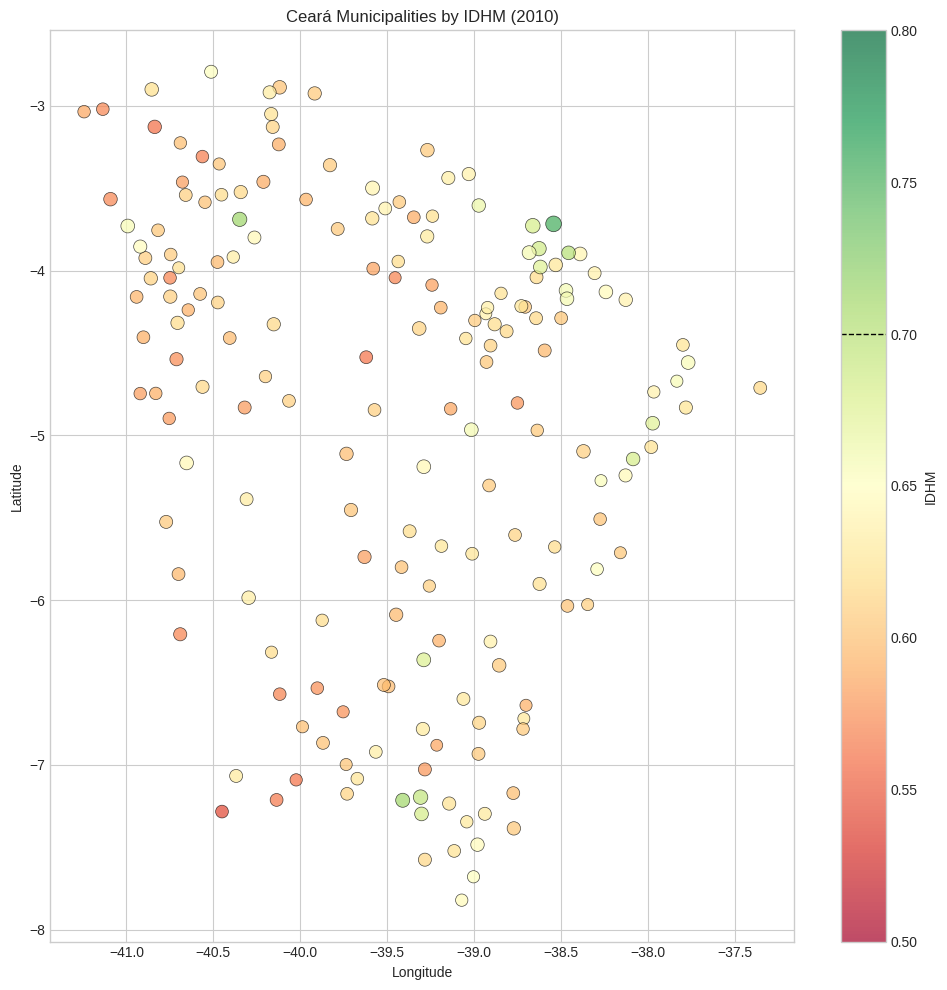


=== IDHM Distribution ===
Lowest IDHM:  Salitre (0.540)
Highest IDHM: Fortaleza (0.754)
Mean IDHM:    0.617

Municipalities below 0.6 (low development): 49


In [6]:
# Plot municipalities colored by IDHM
fig, ax = plt.subplots(figsize=(10, 10))

# Size points by population (log scale for visibility)
sizes = np.log10(df["population"]) * 20

# Color by IDHM
scatter = ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.7, 
                     c=df["idhm"], cmap="RdYlGn", vmin=0.5, vmax=0.8,
                     edgecolors="black", linewidth=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Ceará Municipalities by IDHM (2010)")
cbar = plt.colorbar(scatter, label="IDHM")
cbar.ax.axhline(y=0.7, color='black', linestyle='--', linewidth=1)  # High development threshold
ax.legend()
plt.tight_layout()
plt.show()

# Print IDHM statistics
print("\n=== IDHM Distribution ===")
print(f"Lowest IDHM:  {df.loc[df['idhm'].idxmin(), 'city']} ({df['idhm'].min():.3f})")
print(f"Highest IDHM: {df.loc[df['idhm'].idxmax(), 'city']} ({df['idhm'].max():.3f})")
print(f"Mean IDHM:    {df['idhm'].mean():.3f}")
print(f"\nMunicipalities below 0.6 (low development): {(df['idhm'] < 0.6).sum()}")

---
## 4. Problema de Localização de Serviços

### Definição do Problema

Dados $n$ municípios com:
- Coordenadas $(x_i, y_i)$
- População $P_i$
- IDHM (Índice de Desenvolvimento Humano Municipal) $H_i$

Definimos um **índice de necessidade** que prioriza municípios com maiores populações E menor desenvolvimento:

$$N_i = P_i \times (1 - H_i)$$

Isso significa:
- Um município com alta população mas alto IDHM tem necessidade moderada
- Um município com alta população e baixo IDHM tem alta necessidade
- Um município com baixa população e baixo IDHM tem necessidade moderada

Encontrar localizações ótimas para $k$ centros de serviço que minimizem a distância ponderada pelo **índice de necessidade**.

### Abordagens

1. **Centroide ponderado por necessidade** - Localização de instalação única priorizando áreas carentes
2. **K-means ponderado por necessidade** - Múltiplas localizações de instalações
3. **Análise de Voronoi** - Cobertura de áreas de serviço

### 4.1 Calcular Índice de Necessidade e Centroide Ponderado

Primeiro, calculamos o índice de necessidade para cada município, depois encontramos o ponto único que minimiza a distância total ponderada por necessidade.

In [7]:
# Calculate need score: population * (1 - IDHM)
# Lower IDHM = higher need, weighted by population
df.loc[:, "need_score"] = df["population"] * (1 - df["idhm"])

print("=== Need Score Analysis ===")
print(f"Need score range: {df['need_score'].min():,.0f} - {df['need_score'].max():,.0f}")
print(f"\nTop 10 municipalities by need score:")
print(df.nsmallest(10, "idhm")[["city", "population", "idhm", "need_score"]].to_string(index=False))

def weighted_centroid(df, weight_col="need_score"):
    """Calculate weighted centroid using specified weight column."""
    total_weight = df[weight_col].sum()
    weighted_lat = (df["lat"] * df[weight_col]).sum() / total_weight
    weighted_lon = (df["lon"] * df[weight_col]).sum() / total_weight
    return weighted_lat, weighted_lon

# Calculate need-weighted centroid
centroid_lat, centroid_lon = weighted_centroid(df, "need_score")
print(f"\nNeed-weighted centroid: ({centroid_lat:.4f}, {centroid_lon:.4f})")

# Compare with population-only centroid
pop_centroid_lat, pop_centroid_lon = weighted_centroid(df, "population")
print(f"Population-weighted centroid: ({pop_centroid_lat:.4f}, {pop_centroid_lon:.4f})")

# Find nearest city to need-weighted centroid
df.loc[:, "dist_to_centroid"] = np.sqrt((df["lat"] - centroid_lat)**2 + (df["lon"] - centroid_lon)**2)
nearest_city = df.loc[df["dist_to_centroid"].idxmin()]
print(f"\nNearest city to need-weighted centroid: {nearest_city['city']} (IDHM: {nearest_city['idhm']:.3f})")

=== Need Score Analysis ===
Need score range: 2,009 - 597,462

Top 10 municipalities by need score:
           city  population  idhm  need_score
        Salitre     16633.0 0.540    7651.180
         Granja     53344.0 0.559   23524.704
        Itatira     20424.0 0.562    8945.712
        Potengi      8833.0 0.562    3868.854
        Araripe     19783.0 0.564    8625.388
         Uruoca     13746.0 0.566    5965.764
General Sampaio      6734.0 0.568    2909.088
         Aiuaba     14076.0 0.569    6066.756
          Graça     13801.0 0.570    5934.430
        Parambu     31445.0 0.570   13521.350

Need-weighted centroid: (-4.5655, -39.2306)
Population-weighted centroid: (-4.4959, -39.1458)

Nearest city to need-weighted centroid: Canindé (IDHM: 0.612)


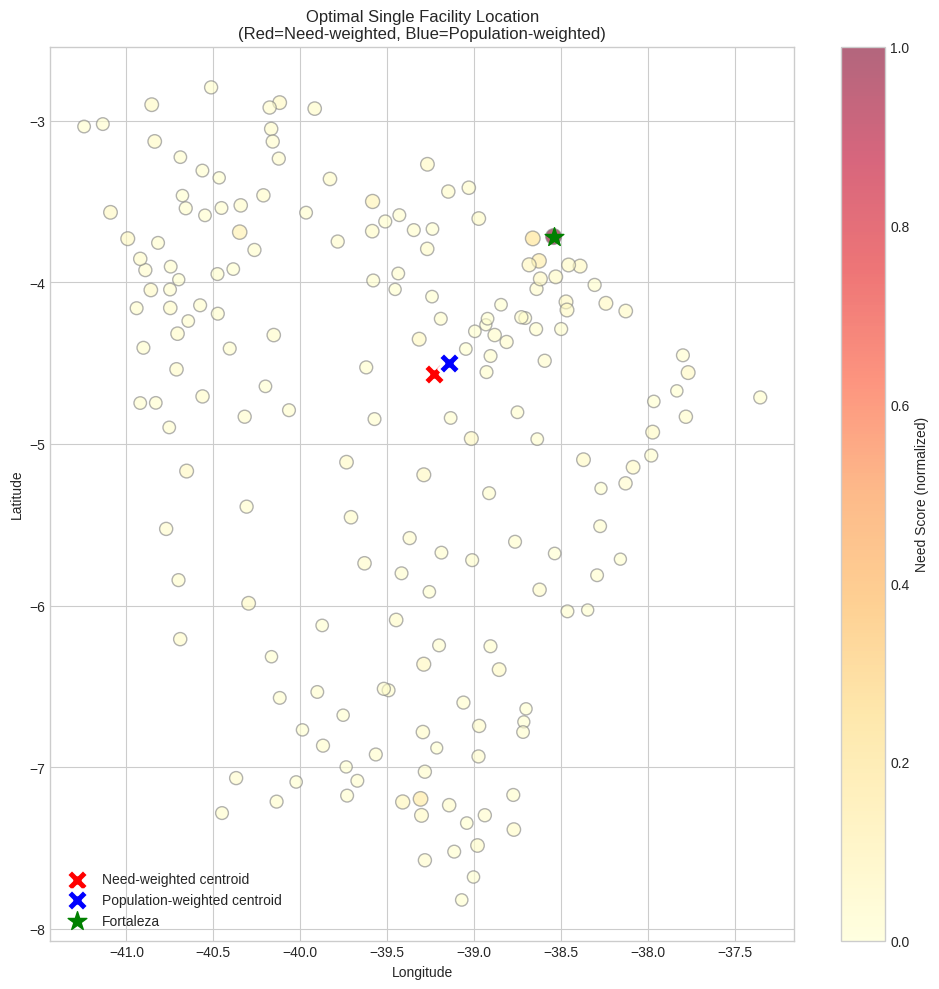

In [9]:
# Visualize centroids with need score coloring
fig, ax = plt.subplots(figsize=(10, 10))

sizes = np.log10(df["population"]) * 20
# Color by need score (normalized)
need_norm = (df["need_score"] - df["need_score"].min()) / (df["need_score"].max() - df["need_score"].min())
scatter = ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.6, 
                     c=need_norm, cmap="YlOrRd", edgecolors="gray")

# Mark need-weighted centroid
ax.scatter(centroid_lon, centroid_lat, s=250, c="red", marker="X", 
           label="Need-weighted centroid", zorder=5, edgecolors="white", linewidth=2)

# Mark population-weighted centroid for comparison
ax.scatter(pop_centroid_lon, pop_centroid_lat, s=250, c="blue", marker="X", 
           label="Population-weighted centroid", zorder=5, edgecolors="white", linewidth=2)

# Mark Fortaleza for reference
fortaleza = df[df["city"] == "Fortaleza"]
if len(fortaleza) > 0:
    ax.scatter(fortaleza["lon"], fortaleza["lat"], s=200, c="green", 
               marker="*", label="Fortaleza", zorder=5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Optimal Single Facility Location\n(Red=Need-weighted, Blue=Population-weighted)")
plt.colorbar(scatter, label="Need Score (normalized)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

### 4.2 K-Means Ponderado por Necessidade para Múltiplas Instalações

Encontrar $k$ localizações ótimas para centros de serviço, ponderadas pelo índice de necessidade (população × inverso do IDHM).

In [10]:
def weighted_kmeans(df, k, weight_col="need_score", max_iter=100):
    """
    Weighted k-means clustering.
    Each iteration assigns cities to nearest center, then recalculates
    centers as weighted centroids of assigned cities.
    
    Parameters:
    - df: DataFrame with lat, lon, and weight column
    - k: number of clusters
    - weight_col: column to use for weighting (default: need_score)
    - max_iter: maximum iterations
    """
    np.random.seed(42)
    coords = df[["lat", "lon"]].values
    weights = df[weight_col].values
    
    # Initialize centers from random cities (weighted by need score)
    probs = weights / weights.sum()
    initial_idx = np.random.choice(len(df), size=k, replace=False, p=probs)
    centers = coords[initial_idx].copy()
    
    for iteration in range(max_iter):
        # Assign each city to nearest center
        distances = cdist(coords, centers)
        assignments = np.argmin(distances, axis=1)
        
        # Recalculate centers as weighted centroids
        new_centers = np.zeros_like(centers)
        for c in range(k):
            mask = assignments == c
            if mask.sum() > 0:
                cluster_weights = weights[mask]
                total_weight = cluster_weights.sum()
                new_centers[c] = (coords[mask] * cluster_weights[:, np.newaxis]).sum(axis=0) / total_weight
            else:
                new_centers[c] = centers[c]
        
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return centers, assignments

# Find 10 optimal locations using need score weighting
k = 10
centers, assignments = weighted_kmeans(df, k, weight_col="need_score")

print(f"Found {k} optimal facility locations (need-weighted):\n")
for i, (lat, lon) in enumerate(centers):
    # Find nearest city
    distances = np.sqrt((df["lat"] - lat)**2 + (df["lon"] - lon)**2)
    nearest_idx = distances.idxmin()
    nearest = df.loc[nearest_idx]
    
    # Calculate cluster statistics
    cluster_mask = assignments == i
    cluster_pop = df.loc[cluster_mask, "population"].sum()
    cluster_need = df.loc[cluster_mask, "need_score"].sum()
    cluster_avg_idhm = df.loc[cluster_mask, "idhm"].mean()
    
    print(f"Center {i+1}: nearest to {nearest['city']}")
    print(f"  Population served: {cluster_pop:,.0f}")
    print(f"  Avg IDHM in cluster: {cluster_avg_idhm:.3f}")
    print(f"  Total need score: {cluster_need:,.0f}\n")

Found 10 optimal facility locations (need-weighted):

Center 1: nearest to Fortaleza
  Population served: 3,479,121
  Avg IDHM in cluster: 0.677
  Total need score: 939,981

Center 2: nearest to Umirim
  Population served: 647,308
  Avg IDHM in cluster: 0.607
  Total need score: 247,949

Center 3: nearest to Independência
  Population served: 534,480
  Avg IDHM in cluster: 0.609
  Total need score: 205,471

Center 4: nearest to Russas
  Population served: 535,625
  Avg IDHM in cluster: 0.634
  Total need score: 189,998

Center 5: nearest to Barreira
  Population served: 584,431
  Avg IDHM in cluster: 0.622
  Total need score: 215,267

Center 6: nearest to Juazeiro do Norte
  Population served: 924,900
  Avg IDHM in cluster: 0.620
  Total need score: 316,652

Center 7: nearest to Guaraciaba do Norte
  Population served: 599,576
  Avg IDHM in cluster: 0.605
  Total need score: 232,251

Center 8: nearest to Jaguaribe
  Population served: 268,441
  Avg IDHM in cluster: 0.616
  Total need s

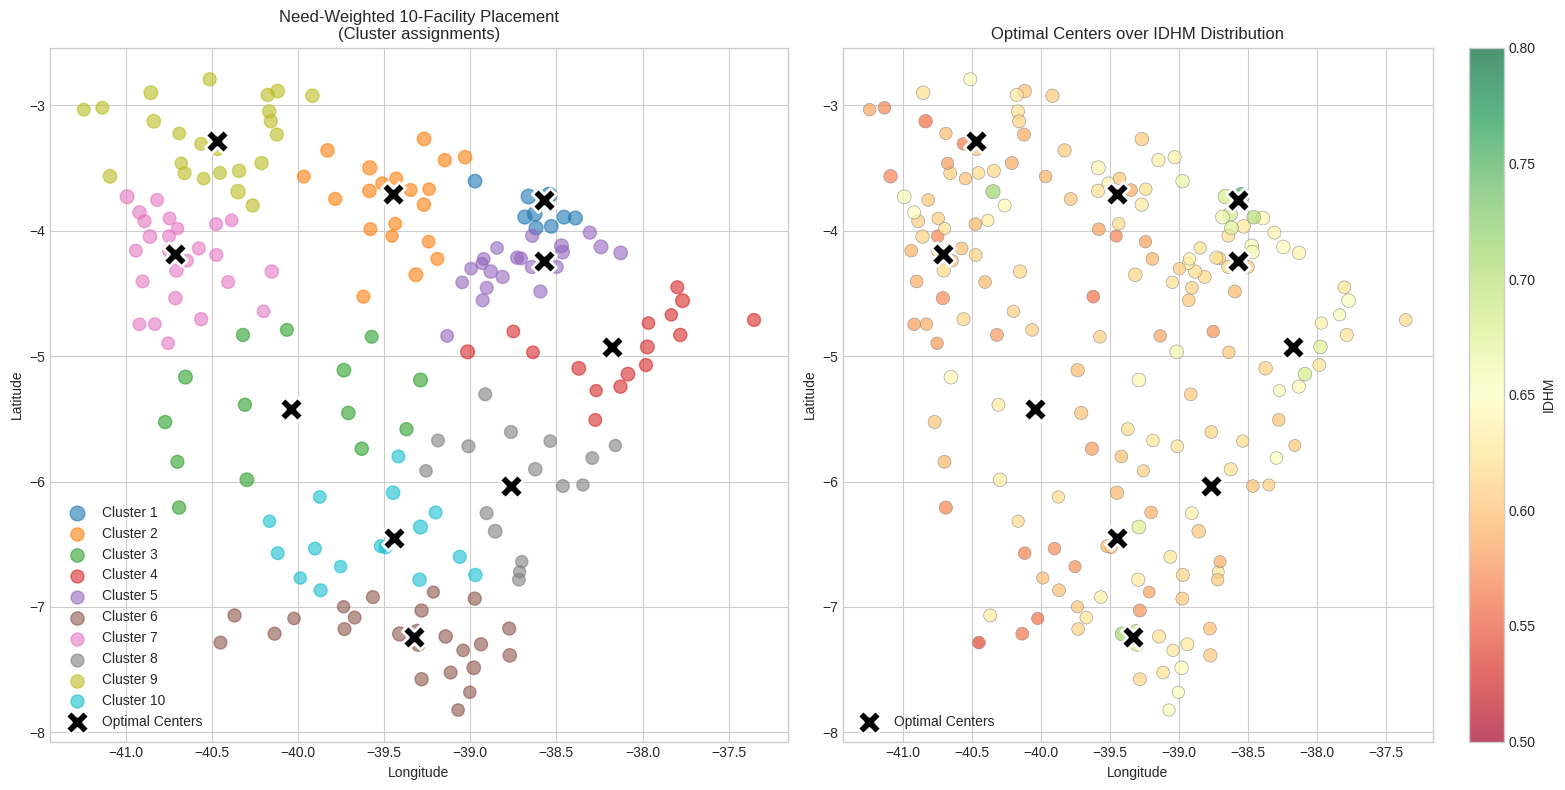

In [11]:
# Visualize k-means results with IDHM coloring
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sizes = np.log10(df["population"]) * 20

# Left plot: Clusters
ax = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, k))
for i in range(k):
    mask = assignments == i
    ax.scatter(df.loc[mask, "lon"], df.loc[mask, "lat"], 
               s=sizes[mask], alpha=0.6, c=[colors[i]], label=f"Cluster {i+1}")

ax.scatter(centers[:, 1], centers[:, 0], s=300, c="black", marker="X", 
           edgecolors="white", linewidth=2, label="Optimal Centers", zorder=5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Need-Weighted {k}-Facility Placement\n(Cluster assignments)")
ax.legend(loc="lower left")

# Right plot: IDHM distribution with centers
ax = axes[1]
scatter = ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.7, 
                     c=df["idhm"], cmap="RdYlGn", vmin=0.5, vmax=0.8,
                     edgecolors="gray", linewidth=0.5)
ax.scatter(centers[:, 1], centers[:, 0], s=300, c="black", marker="X", 
           edgecolors="white", linewidth=2, label="Optimal Centers", zorder=5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Optimal Centers over IDHM Distribution")
plt.colorbar(scatter, ax=ax, label="IDHM")
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

### 4.3 Análise de Diagrama de Voronoi

Analisar áreas de serviço utilizando tesselação de Voronoi.

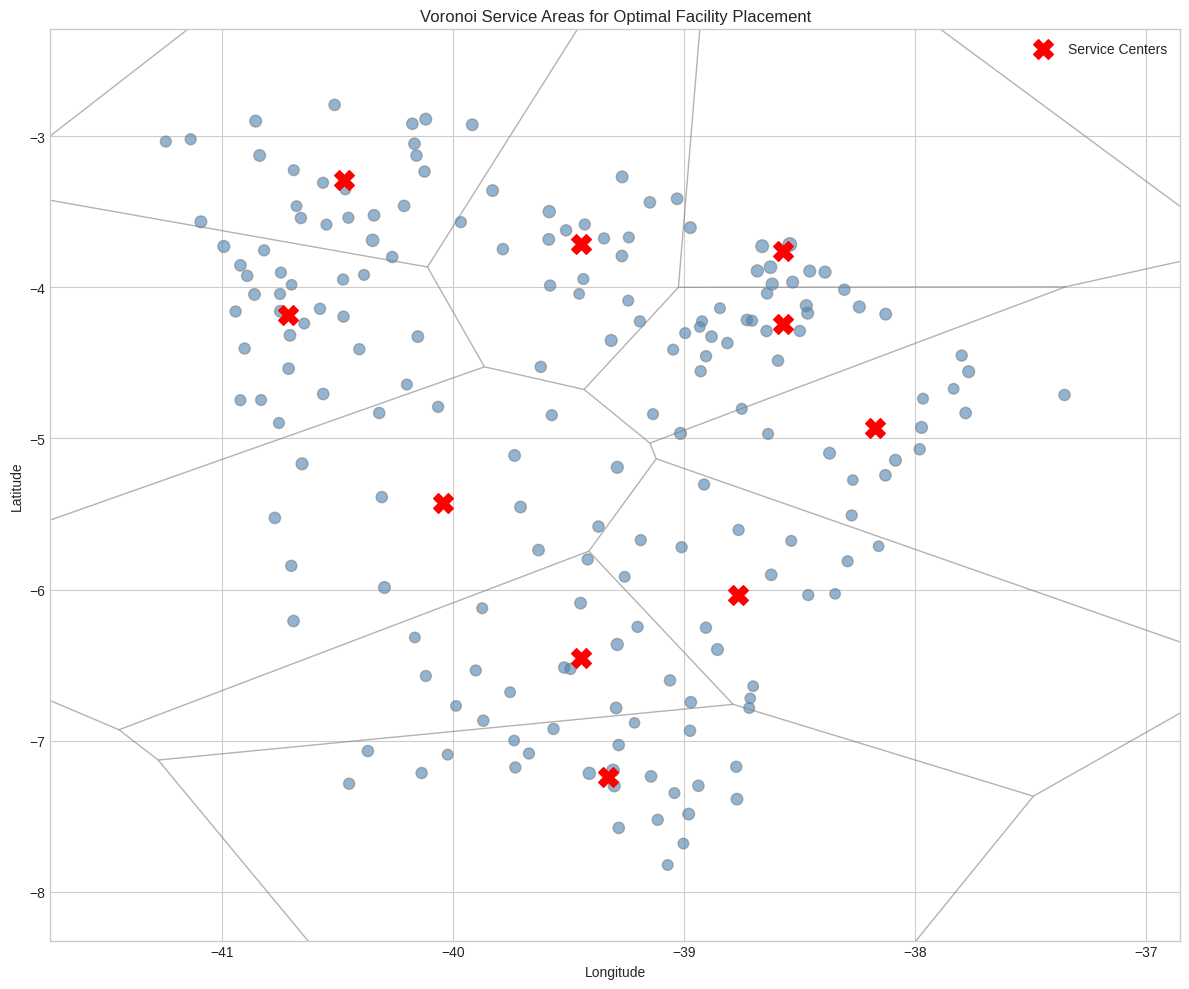

In [12]:
# Create Voronoi diagram from optimal centers
# Note: Voronoi needs at least 3 points and works best with more
from scipy.spatial import Voronoi, voronoi_plot_2d

# Use (lon, lat) for Voronoi (x, y order)
center_points = np.column_stack([centers[:, 1], centers[:, 0]])  # (lon, lat)

# Add boundary points to close the Voronoi regions
lon_min, lon_max = df["lon"].min() - 1, df["lon"].max() + 1
lat_min, lat_max = df["lat"].min() - 1, df["lat"].max() + 1

boundary_points = np.array([
    [lon_min, lat_min], [lon_min, lat_max],
    [lon_max, lat_min], [lon_max, lat_max]
])

all_points = np.vstack([center_points, boundary_points])
vor = Voronoi(all_points)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', 
                line_width=1, line_alpha=0.6, point_size=0)

# Plot cities
sizes = np.log10(df["population"]) * 15
ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.6, c="steelblue", edgecolors="gray")

# Plot centers
ax.scatter(center_points[:, 0], center_points[:, 1], s=200, c="red", 
           marker="X", label="Service Centers", zorder=5)

ax.set_xlim(lon_min + 0.5, lon_max - 0.5)
ax.set_ylim(lat_min + 0.5, lat_max - 0.5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Voronoi Service Areas for Optimal Facility Placement")
ax.legend()
plt.tight_layout()
plt.show()

---
## 5. Conclusões e Recomendações

### Metodologia

Esta análise utilizou o IDHM (Índice de Desenvolvimento Humano Municipal) como métrica socioeconômica para otimizar a localização de serviços governamentais. Definimos um **índice de necessidade** combinando população e necessidades de desenvolvimento:

$$\text{Índice de Necessidade} = \text{População} \times (1 - \text{IDHM})$$

Isso prioriza municípios que são tanto populosos QUANTO possuem menor desenvolvimento humano.

**Flexibilidade e Adaptabilidade**: Esta metodologia pode ser facilmente adaptada para outros contextos. A função `fetch_municipal_data()` suporta qualquer uma das mais de 500 séries em nível municipal disponíveis no IPEADATA (ex.: taxas de pobreza, analfabetismo, mortalidade infantil, acesso a saneamento). Basta alterar o parâmetro `uf_code` para analisar outros estados brasileiros, ou modificar a fórmula do índice de necessidade para ponderar diferentes fatores socioeconômicos de acordo com o serviço específico sendo localizado (ex.: clínicas de saúde podem priorizar taxas de mortalidade infantil, enquanto centros educacionais podem priorizar analfabetismo).

### Principais Descobertas

1. **Distribuição do IDHM**: Os municípios do Ceará apresentam variação significativa no desenvolvimento humano, com algumas áreas necessitando de mais atenção que outras.

2. **Localizações Ótimas**: A análise k-means ponderada por necessidade identificou localizações de centros de serviço que equilibram cobertura populacional com necessidade socioeconômica.

3. **Áreas de Serviço Voronoi**: O diagrama de Voronoi mostra territórios de serviço claros para cada centro ótimo, permitindo alocação eficiente de recursos.

### Recomendações

1. **Áreas Prioritárias**: Municípios com baixo IDHM devem ser priorizados para novos serviços governamentais ou unidades móveis de atendimento.

2. **Localização de Centros de Serviço**: Os centros ótimos identificados representam localizações que maximizam o impacto ao atender tanto a densidade populacional quanto as necessidades de desenvolvimento.

3. **Considerações de Equidade**: Usar otimização ponderada por necessidade (vs. apenas população) ajuda a garantir que os serviços alcancem comunidades carentes, não apenas as áreas mais populosas.

---
## Referências

- IPEADATA: http://www.ipeadata.gov.br/
- IBGE: https://www.ibge.gov.br/
- Dataset Municípios Brasileiros: https://github.com/kelvins/Municipios-Brasileiros
- Documentação ipeadatapy: https://www.luanborelli.net/ipeadatapy/docs/